# PDG Averaging

This is a little function definition with some tests which demonstrate how a PDG average is made.
The function can also make the PDG "ideograms" which are made for "inconsistent" averages, although the formatting is not as pretty

In [1]:
import numpy as np
from scipy.stats import chi2
from scipy.stats import norm

import matplotlib.pyplot as plt

from tabulate import tabulate # great for printing info
from uncertainties import ufloat # I use this to print the results because it implements the PDG rounding rule

def make_pdg_average( inputs, pdg_scale=False, plot=False, ax=None, posterior=False, xrange=None, yrange=None, xlabel=None, ylabel=None ):
    
    # input should be a list of tuples containing (value, error)
    # if more than one error add them in quadrature
    for i, inp in enumerate(inputs):
        assert( len(inp)>=2 )
        if len(inp)>2:
            inputs[i] = tuple( (inp[0],np.sqrt( np.sum( [inp[i]**2 for i in range(1,len(inp)) ] ) ) ) )
            
    # get values, errs and wts (1/err^2) as np arrays
    xis = np.array( [ x[0] for x in inputs ] )
    sis = np.array( [ x[1] for x in inputs ] )
    wis = np.array( [ 1/x[1]**2 for x in inputs ] )
    
    # make the weighted average
    xbar = np.sum( wis*xis ) / np.sum( wis )
    
    # get the raw error
    rawerr  = 1/np.sqrt(np.sum( wis ) )
    
    # compute the contributing chi2s
    c2is = wis * ( xbar - xis ) ** 2
    
    # now do the scaling if the chi2 > (N-1)
    scale = 1
    if np.sum(c2is) > len(inputs)-1 and pdg_scale:
        
        # first we have to check which results are in the threshold for the scaling
        thresh = 3*rawerr*len(inputs)**0.5
        xis_inthresh = xis[ sis < thresh ]
        sis_inthresh = sis[ sis < thresh ]
        wis_inthresh = wis[ sis < thresh ]
        
        # compute the weighted average of results in threshold
        xbar_inthresh = np.sum( wis_inthresh*xis_inthresh ) / np.sum( wis_inthresh )
        
        # compute the chi2 of results in threshold
        chi2_inthresh = np.sum( wis_inthresh * ( xbar_inthresh - xis_inthresh )**2 )
        
        # now we can get the scale factor for the rawerr
        scale = (chi2_inthresh / ( len(inputs)-1 ) )**0.5
        
    err = rawerr*scale
        
    # make the plot if asked
    if plot:            
        ax = ax or plt.gca()
        
        # configure the y-axis limit
        ylim = (0, len(xis)) if yrange is None else yrange
        
        # draw the scaled error bar
        if scale!=1:
            ax.fill_between( [xbar-err, xbar+err], ylim[0], ylim[1], alpha=0.5, color='0.8', label='Scaled Average')
        
        # draw the raw error bar
        ax.fill_between( [xbar-rawerr,xbar+rawerr], ylim[0], ylim[1], alpha=0.5, color='0.6', label='Average' )
    
        # draw the average line
        ax.plot( [xbar,xbar], ylim, 'k--' )
    
        # draw the input measurement points
        ax.errorbar( xis, np.arange(len(xis))+0.5, xerr=sis, fmt='ko', label='Input Measurements' )
    
        # now can compute the xlimits
        xlim = ax.get_xlim() if xrange is None else xrange
        
        # make the pvalue line (sum of the input Gaussians)
        if scale!=1:
            x = np.linspace(*xlim, 400)
            y = np.sum( np.array( [ norm( xis[i], sis[i] ).pdf(x)/sis[i] for i in range(len(inputs)) ] ), axis=0 )
            y *= ylim[1]/np.max(y)
        
            # draw the posterior if asked (should be equivalent to the raw error bar)
            if posterior:
                ypost = np.prod( np.array( [ norm( xis[i], sis[i] ).pdf(x) for i in range(len(inputs)) ] ), axis=0 )
                ypost *= ylim[1]/np.max(ypost)
                ax.plot(x,ypost,'k:',label='Posterior')
        
            ax.plot(x,y,'k-',label='Weighted Sum')
        
        # now set the xlimits
        ax.set_xlim(*xlim)
        
        # write the yticks
        ax.set_yticks( np.arange(len(xis))+0.5 )
        ax.set_yticklabels( range(1,len(xis)+1) )
        
        # add the contributing chi2s
        for i, c2 in enumerate(c2is):
            ax.text( xlim[1]+0.08*(xlim[1]-xlim[0]), i+0.5, '{:4.1f}'.format(c2), ha='right' )
            
        # and the sum chi2
        ax.text(xlim[1]+0.08*(xlim[1]-xlim[0]), 0, '{:4.1f}'.format(np.sum(c2is)), ha='right')
        
        # put a chi2 title
        ax.text(xlim[1]+0.06*(xlim[1]-xlim[0]), ylim[1], ' $\chi^{2}$', ha='center')
        
        # add the CL (really it's the p-value or 1-CL)
        ax.text(xlim[1]+0.08*(xlim[1]-xlim[0]), -0.1*(ylim[1]-ylim[0]), 'CL = {:6.4f}'.format(1-chi2.cdf(np.sum(c2is),len(xis)-1)),ha='right')
        
        # set the ylimits
        ax.set_ylim( ylim )
        
        # add axis labels
        xlabel = xlabel or 'Measured value'
        ylabel = ylabel or 'Measurement'
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        
        # draw the legend
        ax.legend()        
        
    # print a nice table to summarise what we've done
    print('Made PDG Average:')
    rows = [ [ i, inputs[i][0], inputs[i][1], c2is[i] ] for i in range(len(inputs)) ]
    rows.append( ['Raw Average', xbar, rawerr, np.sum(c2is)] )
    print(tabulate(rows,headers=['Measurement','Value','Error','Chi2']))
    if scale!=1:
        print( 'Found chi2>N-1. Thresh=', thresh, 'S=', scale)
    print('Quoted Average', ufloat(xbar,err))
    return xbar, err, ax



Can now run a little test on some intentionally inconsistent data.
Notice how large the error ends up getting scaled by (a factor of 3!).
It just so happens in this case that the two measurements with the large error end up being just under the threshold for scaling. This mean that if the middle measurement was just a little more precise the scaling would vanish as these other two would fall outside the threshold. It means that you can sometimes get quite sudden improvements in the PDG error of a quantity without a huge amount of additional.

Made PDG Average:
Measurement      Value      Error       Chi2
-------------  -------  ---------  ---------
0              1.5      0.2         2.73805
1              1.2      0.05        0.382941
2              0.5      0.18       13.816
Raw Average    1.16906  0.0468363  16.937
Found chi2>N-1. Thresh= 0.24336837345828066 S= 2.9100716940868994
Quoted Average 1.17+/-0.14


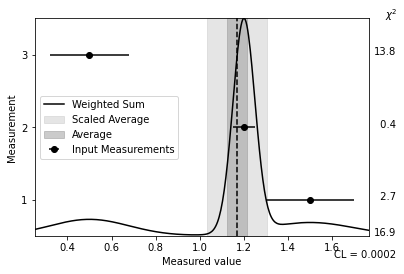

In [2]:
example_measurements = [ (1.5, 0.2 ) , (1.2, 0.05), (0.5,0.18) ]

x,err,ax = make_pdg_average( example_measurements, plot=True, pdg_scale=True )


It also seems sensible to check the code on an actual PDG example. So find a random one from hadron multiciplicity of Z decays. Find this on (Page 26 of PDG 2018)[https://pdg.lbl.gov/2018/listings/rpp2018-list-z-boson.pdf].

See in this case that we get a reasonable large scaling again even though by eye all of the measurements seem reasonably consistent.

Made PDG Average:
Measurement      Value      Error      Chi2
-------------  -------  ---------  --------
0              2.093    0.0292746  3.40019
1              2.01     0.08       0.131577
2              2.024    0.0424264  0.125314
3              1.962    0.0601664  1.63865
4              1.99     0.0412311  1.41344
Raw Average    2.03902  0.0190931  6.70917
Found chi2>N-1. Thresh= 0.12808016184378412 S= 1.2951033372160052
Quoted Average 2.039+/-0.025


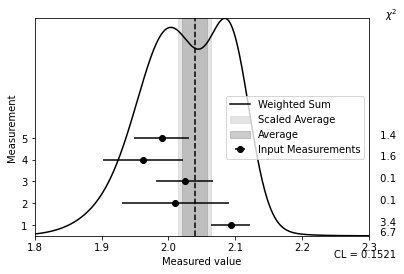

In [3]:
z_check = [ (2.093, 0.004, 0.029), (2.01,0.08), (2.024,0.006,0.042), (1.962,0.022,0.056), (1.99,0.01,0.04) ]
x,err,ax = make_pdg_average( z_check, plot=True, pdg_scale=True, xrange=(1.8,2.3), yrange=(0,10) )